In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

np.random.seed(1337)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

# Data

In [ ]:
# load the training data from the respective filepaths
train_features_filepath = 'data/train_features.csv'
test_features_filepath = 'data/test_features.csv'
train_labels_filepath = 'data/train_labels.csv'

# create the dataframes
train_features_df = pd.read_csv(train_features_filepath, float_precision="round_trip")
test_features_df = pd.read_csv(test_features_filepath, float_precision="round_trip")
train_labels_df = pd.read_csv(train_labels_filepath, float_precision="round_trip")
print("Train shape:", train_features_df.shape, "| Train label shape:", train_labels_df.shape, "| Test shape:", test_features_df.shape)
display(train_features_df.head(40))
display(train_labels_df.head(40))
display(test_features_df.head(30))

display(train_features_df.describe())
display(train_labels_df.describe())

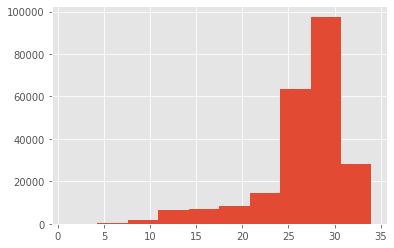

'Number of instances: 227940'

In [61]:
import matplotlib.pyplot as plt

# Plots the number of rows that have 'NaN' values
plt.style.use('ggplot')
plt.hist(train_features_df.isnull().sum(axis=1), bins=10)
plt.show()

display("Number of instances: {}".format(train_features_df.shape[0]))

# KNN Imputer

In [148]:
from sklearn.impute import KNNImputer
import multiprocessing

# Train set for imputing, contains labels
impute_train_fit_set = train_features_df.merge(train_labels_df, on='pid', how='left')

# Test set for imputing, contains labels with NaN values
impute_test_labels = pd.DataFrame(np.nan, index=train_labels_df.index, columns=train_labels_df.columns)
impute_test_set = test_features_df.merge(impute_test_labels, on='pid', how='left')

#imputer = KNNImputer(n_neighbors=4)
#imputer.fit(impute_train_fit_set.iloc[:, 2:])

def impute_df_knn(df, imputer, save_dest):
    print("[Impute] set has NaN values: {}".format(train_features_df.isnull().values.any()))
    print("[Impute] Starting KNN Imputation")
    
    # For each patient measurement column, fill the ones that are completely 'NaN'
    """measurement_cols = train_features_df.columns[2:]
    print(measurement_cols)
    display(df.head(30))
    for pid in tqdm(df['pid'].unique()):
        patient_rows = df.loc[df['pid'] == pid]
        for column in measurement_cols:
            # If all column values are 'NaN'
            if patient_rows[column].isnull().all():
                patient_rows[column].fillna(-10)
        
        df.loc[df['pid'] == pid] = patient_rows"""
    
    # Impute with KNNImputer
    nr_chunks = 1000
    for train_chunk in tqdm(np.array_split(df.iloc[:, 2:], nr_chunks)):
        train_chunk_filled = imputer.transform(train_chunk)
        df.iloc[train_chunk.index, 2:] = train_chunk_filled

    print("[Impute] Finished KNN Imputation, saving to '{}'.".format(save_dest))                                         
    print("[Impute] set has NaN values: {}".format(train_features_df.isnull().values.any()))
    df.to_csv(save_dest, index=False)
    
    return df

#impute_result = impute_df_knn(impute_train_fit_set, imputer, 'data/train_features_imputed.csv')

In [ ]:
display(impute_result.shape, train_features_df.shape)
display(impute_result.iloc[:, 2:37].shape)
display(impute_result.columns[2:37])

display(train_features_df.head(8))
train_features_df_grouped = train_features_df.loc[:, train_features_df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.nanmean)
train_features_nan_mask = train_features_df_grouped.isnull()
display(train_features_nan_mask.head(30))
display(train_features_df[train_features_nan_mask].head(30))
train_features_df_imputed = impute_result.iloc[:, 0:37].copy()
train_features_df.iloc[:, 2:] = impute_result.iloc[:, 2:37]
X_df = train_features_df_imputed.loc[:, train_features_df_imputed.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.mean)
X_df[train_features_nan_mask] = -10
display(X_df.head(8))

In [151]:
# Impute the test set
imputer = KNNImputer(n_neighbors=4)
imputer.fit(train_features_df.iloc[:, 2:])
impute_test_result = impute_df_knn(test_features_df, imputer, 'data/test_features_imputed.csv')

[Impute] set has NaN values: False
[Impute] Starting KNN Imputation


100%|██████████| 1000/1000 [10:03:01<00:00, 36.18s/it]


[Impute] Finished KNN Imputation, saving to 'data/test_features_imputed.csv'.
[Impute] set has NaN values: False


In [ ]:
display(impute_test_result.head(8))
display(test_features_df.head(8))
test_features_df_grouped = test_features_df.loc[:, train_features_df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.nanmean)
test_features_nan_mask = test_features_df_grouped.isnull()
display(test_features_nan_mask.head(30))
display(test_features_df[test_features_nan_mask].head(30))

test_features_df_imputed = impute_test_result.iloc[:, 0:37].copy()
test_features_df.iloc[:, 2:] = impute_test_result.iloc[:, 2:37]
X_test_df = test_features_df_imputed.loc[:, test_features_df_imputed.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.mean)
X_test_df[test_features_nan_mask] = -10
display(X_test_df.head(8))

In [ ]:
display(test_features_df.head(1200))

## Grouping

* groupby the `'pid'` column values for each age range from `[0, 20, 30, 40, 50, 60, 70, 80, 110]`
* ignore `'Time'` col

In [51]:
def group_columns_in_df(df):
    """age_ranges = [0, 20, 30, 40, 50, 60, 70, 80, 110]
    dfs = []
    for i in range(len(age_ranges) - 1):
        age_l = age_ranges[i]
        age_u = age_ranges[i+1]
        sub_df = df[(df['Age'] >= age_l) & (df['Age'] < age_u)]
        sub_df = sub_df.loc[:, sub_df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.median)
        sub_df = sub_df.fillna(-10)
        dfs.append(sub_df)
    grouped_df = df.loc[:, df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.nanmean)
    result = grouped_df.copy()
    result.update(result[['pid']].merge(pd.concat(dfs)))
    result = result.astype({"pid": int})
    assert(grouped_df.shape == result.shape)
    assert(not grouped_df.equals(result))
    return result"""
    
    return df.loc[:, df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.mean)

X_df = group_columns_in_df(train_features_df)
display(X_df.shape)
display(X_df.head(20))

X_test_df = group_columns_in_df(test_features_df)

(18995, 36)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,34.0,35.125000,28.741667,13.625000,1.628958,36.916667,9.676042,24.614583,-0.333333,17.000000,255.354167,2.862500,8.568750,0.848958,39.687500,532.625000,0.488750,158.250000,97.708333,126.062500,68.333333,1.900000,3.775000,50.250000,8.072917,116.812500,100.000000,1.654583,109.291667,26.670833,77.083333,4.622917,0.015833,114.500000,7.386875
1,10,71.0,30.125000,50.033333,36.354167,3.103333,36.437500,12.056250,21.064583,-2.947917,18.250000,185.479167,4.104167,9.120833,3.842500,38.158333,36.395833,0.477500,228.333333,91.770833,165.041667,101.916667,2.066667,4.097917,83.770833,8.740000,68.250000,98.041667,0.470417,105.520833,32.077083,78.770833,1.608333,0.221250,132.791667,7.364792
2,100,68.0,33.604167,46.041667,18.145833,2.702083,36.500000,10.929167,24.497917,-1.785417,14.833333,265.208333,3.393750,11.566667,0.996667,38.906250,26.312500,0.778125,167.041667,98.770833,159.781250,81.833333,1.820833,4.110417,62.833333,7.157500,89.479167,96.500000,1.130417,102.916667,32.372917,109.083333,0.979167,41.643542,117.770833,7.394583
3,1000,79.0,31.916667,64.300000,21.000000,2.339792,36.812500,9.866667,24.991667,-0.012500,12.416667,193.510417,3.206250,13.710417,0.955208,40.035417,262.333333,0.728958,157.000000,89.875000,145.625000,83.354167,1.806250,3.786875,63.052083,4.331875,64.666667,98.916667,0.351458,104.958333,28.619792,85.750000,0.732292,2.265000,143.270833,7.363333
4,10000,76.0,31.812500,33.039583,17.270833,1.868750,36.687500,11.954167,24.381250,-0.058333,12.104167,236.708333,3.322917,8.785417,0.836250,42.458333,35.625000,0.507500,170.854167,98.375000,142.843750,69.437500,1.910417,4.017500,48.406250,5.477917,69.187500,98.500000,0.921250,105.458333,32.560417,77.041667,1.779167,0.950000,123.145833,7.378542
5,10002,73.0,33.500000,64.043750,38.458333,3.022917,36.979167,9.106250,24.054167,-0.541667,18.645833,175.427083,3.968750,8.789583,2.353750,42.625000,54.500000,0.706250,172.791667,95.145833,148.437500,69.583333,1.910417,4.441667,48.322917,7.491667,109.854167,99.166667,1.102917,106.312500,27.225000,67.145833,1.845833,1.182708,130.875000,7.365625
6,10006,51.0,33.958333,38.470833,15.500000,2.612917,36.750000,9.368750,23.585417,0.687500,18.729167,271.666667,3.618750,10.525000,0.855208,45.437500,141.000000,0.601042,161.729167,94.729167,154.333333,69.604167,1.818750,3.829167,49.947917,7.940000,138.395833,96.375000,1.963333,105.937500,28.039583,81.937500,0.931250,0.537083,116.041667,7.378125
7,10007,60.0,38.343750,59.372917,24.708333,2.132083,37.104167,13.358333,24.350000,-1.093750,21.979167,384.479167,3.127083,12.218750,0.882708,38.006250,39.437500,0.605833,241.020833,95.687500,142.083333,107.104167,1.937500,4.079167,87.437500,8.920833,200.666667,95.020833,0.491458,105.937500,39.956250,78.895833,0.870833,8.304167,137.937500,7.400833
8,10009,69.0,32.364583,44.908333,16.854167,3.687500,36.979167,9.466667,24.916667,2.822917,23.020833,196.802083,3.902083,8.248958,0.997917,46.114583,51.520833,0.612500,198.000000,93.375000,166.895833,65.791667,1.835417,3.918750,65.239583,8.187500,85.500000,97.062500,0.671042,104.125000,28.722917,97.750000,0.812500,14.782083,90.562500,7.390208
9,1001,36.0,34.854167,33.354167,10.520833,2.047292,37.333333,10.335417,26.120833,6.979167,13.291667,313.145833,2.925000,8.200000,0.658750,38.750000,200.145833,0.431458,179.979167,97.458333,114.395833,85.770833,1.916667,3.495833,69.666667,6.793333,141.208333,99.979167,3.140833,108.375000,30.004167,106.666667,0.887500,4.900208,113.062500,7.514583


## Adding features

In [ ]:
def max_abs_diff_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        min_val = np.nanmin(x)
        max_val = np.nanmax(x)
        res = np.abs(max_val - min_val)
        return res

def std_dev_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        return np.nanstd(x)
    
def min_agg_fn(x):
    if x.isna().all():
        return -10
    else:
        return np.nanmin(x)
    
def max_agg_fn(x):
    if x.isna().all():
        return -10
    else:
        return np.nanmax(x)


def add_features(df_to_group, df_to_add_features_to, nan_mask):
    """Add maximum absolute difference features for each column to a dataframe
    
    Args:
        df_to_group (pd.DataFrame): the dataframe that will be grouped by 'pid'
        df_to_add_features_to (pd.DataFrame): the dataframe to add new features to
        
    Returns:
        pd.DataFrame: the new dataframe with all features
    """
    nan_mask_noage = nan_mask.loc[:, nan_mask.columns != 'Age']
    grouped_df = df_to_group.drop(['Age', 'Time'], axis=1).groupby('pid', as_index=False, sort=False)
    ## Maximum Absolute Difference
    mad_features_df = grouped_df.agg(max_abs_diff_agg_fn)
    #mad_features_df = grouped_df.agg(np.nanmean)
    mad_features_df.columns = [str(col) + '_diff' for col in mad_features_df.columns]
    nan_mask_noage.columns = mad_features_df.columns
    # Fill NaN with 0
    mad_features_df[nan_mask_noage] = 0
    # Remove 'pid' col from features_df
    mad_features_df = mad_features_df.iloc[:, 1:]
    
    ## Std dev.
    std_features_df = grouped_df.agg(std_dev_agg_fn)
    #std_features_df = grouped_df.agg(np.nanmean)
    std_features_df.columns = [str(col) + '_std' for col in std_features_df.columns]
    nan_mask_noage.columns = std_features_df.columns
    # Fill NaN with 0
    std_features_df[nan_mask_noage] = 0
    # Remove 'pid' col from features_df
    std_features_df = std_features_df.iloc[:, 1:]
    
    ## Min
    min_features_df = grouped_df.agg(np.nanmin)
    #min_features_df = grouped_df.agg(np.nanmean)
    min_features_df.columns = [str(col) + '_min' for col in min_features_df.columns]
    nan_mask_noage.columns = min_features_df.columns
    # Fill NaN with -10
    min_features_df[nan_mask_noage] = -10
    # Remove 'pid' col from features_df
    min_features_df = min_features_df.iloc[:, 1:]
    
    ## Max
    max_features_df = grouped_df.agg(np.nanmax)
    #max_features_df = grouped_df.agg(np.nanmean)
    max_features_df.columns = [str(col) + '_max' for col in max_features_df.columns]
    nan_mask_noage.columns = max_features_df.columns
    # Fill NaN with -10
    max_features_df[nan_mask_noage] = -10
    # Remove 'pid' col from features_df
    max_features_df = max_features_df.iloc[:, 1:]
    
    ## Fever
    df_to_add_features_to['Fever'] = df_to_add_features_to.apply(lambda row: 1 if row['Temp'] >= 37.5 else 0, axis=1)
    
    ## Result
    return pd.concat([
        df_to_add_features_to, 
        mad_features_df, 
        min_features_df,
        max_features_df, 
        std_features_df
    ], axis=1, sort=False)


X_df = add_features(train_features_df, X_df, train_features_nan_mask)

display(X_df.shape)
display(X_df.describe())
display(X_df.head(30))

X_test_df = add_features(test_features_df, X_test_df, test_features_nan_mask)

display(X_test_df.shape)
display(X_test_df.describe())
display(X_test_df.head(30))

X_df_backup = X_df.copy()
X_test_df_backup = X_test_df.copy()

In [50]:
X_df = X_df_backup.copy()
X_test_df = X_test_df_backup.copy()

## Data imputation

In [ ]:
def median_impute_df(df):
    return df.fillna(df.median())

def impute_min_max_df(df):
    filled_cols = [col for col in X_df if (all([not col.endswith(suffix) for suffix in ['_min', '_max', '_diff', '_std']])) and col != 'pid' and col != 'Age']
    df_filled = df[filled_cols].copy()
    
    min_cols = [col for col in X_df if col.endswith('_min')]
    df_filled.columns = min_cols
    df[min_cols] = df[min_cols].fillna(df_filled)
    
    max_cols = [col for col in X_df if col.endswith('_max')]
    df_filled.columns = max_cols
    df[max_cols] = df[max_cols].fillna(df_filled)
    return df

def impute_df(df):
    summarized_cols = ['_min', '_max', '_diff', '_std', '_25%', '_75%']
    filled_cols = [col for col in X_df if (all([not col.endswith(suffix) for suffix in summarized_cols])) and col != 'pid' and col != 'Age' and col != 'Fever']
    df_filled = df[filled_cols].copy()

    assert(df[filled_cols].equals(df_filled.fillna(df_filled.median())))
    min_cols = [col for col in df if col.endswith('_min')]
    df_filled.columns = min_cols
    df[min_cols] = df[min_cols].fillna(df_filled)

    max_cols = [col for col in df if col.endswith('_max')]
    df_filled.columns = max_cols
    df[max_cols] = df[max_cols].fillna(df_filled)
    return df


"""median_cols = [col for col in X_df if not col.endswith('_max') and not col.endswith('_min')]
display(X_df.head(20))
X_df[median_cols] = median_impute_df(X_df[median_cols].copy())
display(X_df.head(30))
X_df = impute_min_max_df(X_df)
display(X_df.head(30))"""

display("------Train------")
display(X_df.head(20))
X_df = impute_df(X_df)
display(X_df.head(20))
display("------Test------")
X_test_df = impute_df(X_test_df)

"""median_cols = [col for col in X_test_df if not col.endswith('_max') and not col.endswith('_min')]
X_test_df[median_cols] = median_impute_df(X_test_df[median_cols].copy())
X_test_df = impute_min_max_df(X_test_df)"""

## Scaling / normalization

In [199]:
from sklearn import preprocessing

# Scale the dataframe
def scale_df(df, scaler=None):
    if scaler is None:
        scaler = preprocessing.MinMaxScaler()
        df.loc[:, df.columns != 'pid'] = scaler.fit_transform(df.loc[:, df.columns != 'pid'])
        return scaler
    else:
        df.loc[:, df.columns != 'pid'] = scaler.transform(df.loc[:, df.columns != 'pid'])
        return scaler

scaler = scale_df(X_df)
display(X_df.describe())
_ = display(X_df.head(30), scaler)

scale_df(X_test_df, scaler)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.0000

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,0.223529,0.000000,0.000000,0.223669,0.000000,0.908065,0.763254,0.767791,0.519110,0.408704,0.000000,0.707216,0.078963,0.517536,0.621579,0.000000,0.020547,0.302563,0.000000,0.287096,0.434180,0.829750,0.833533,0.337791,0.838326,0.000000,1.000000,0.000000,0.919396,0.604547,0.503979,0.000000,0.000000,0.552106,0.989390,0.0,0.000000,0.000000,0.037500,0.000000,0.125000,0.200663,0.116379,0.020833,0.076923,0.000000,0.198795,0.023934,0.016653,0.126866,0.000000,0.000053,0.046317,0.000000,0.022782,0.133621,0.103933,0.083630,0.095142,0.111739,0.000000,0.000000,0.000000,0.232558,0.286421,0.325397,0.000000,0.000000,0.237288,0.145098,0.000000,0.000000,0.194647,0.0000,0.901961,0.760534,0.836538,0.729730,0.468085,0.000000,0.726048,0.071935,0.571973,0.694030,0.000000,0.944318,0.349022,0.000000,0.353492,0.411765,0.905051,0.863419,0.376923,0.847909,0.000000,1.000000,0.000000,0.910180,0.559757,0.419753,0.000000,0.000000,0.528846,0.991135,0.000000,0.000000,0.107014,0.000000,0.923077,0.636834,0.600000,0.126915,0.261682,0.000000,0.553030,0.054778,0.215559,0.500000,0.000000,0.002643,0.094876,0.000000,0.147349,0.303226,0.618622,0.679518,0.235390,0.614379,0.000000,1.000000,0.000000,0.821192,0.576635,0.542289,0.000000,0.000000,0.511785,0.979893,0.000000,0.000000,0.037453,0.000000,0.137836,0.261134,0.128883,0.028661,0.075505,0.000000,0.189004,0.020051,0.016809,0.123162,0.000000,0.000062,0.052573,0.000000,0.016663,0.114125,0.099516,0.107311,0.103951,0.107583,0.000000,0.000000,0.000000,0.143961,0.358384,0.327367,0.000000,0.000000,0.242488,0.159005
1,10,0.658824,0.000000,0.452491,0.438856,0.000000,0.898790,0.855584,0.000000,0.254421,0.427625,0.000000,0.775487,0.081311,0.660339,0.000000,0.011743,0.000000,0.428593,0.000000,0.369343,0.620323,0.841371,0.853073,0.525726,0.869269,0.046444,0.982197,0.000000,0.000000,0.693674,0.513745,0.441626,0.065408,0.633222,0.000000,0.0,0.000000,0.136453,0.115385,0.000000,0.062500,0.248756,0.000000,0.000000,0.102564,0.000000,0.240964,0.006855,0.089742,0.000000,0.005712,0.000000,0.041489,0.000000,0.046163,0.159483,0.092697,0.149466,0.141700,0.233980,0.019592,0.038462,0.000000,0.000000,0

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [200]:
display(X_df.shape, X_test_df.shape)
display(X_df.head(3))
display(X_test_df.head(3))

(18995, 173)

(12664, 173)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,0.223529,0.0,0.000000,0.223669,0.0,0.908065,0.763254,0.767791,0.519110,0.408704,0.0,0.707216,0.078963,0.517536,0.621579,0.000000,0.020547,0.302563,0.0,0.287096,0.434180,0.829750,0.833533,0.337791,0.838326,0.000000,1.000000,0.0,0.919396,0.604547,0.503979,0.000000,0.000000,0.552106,0.98939,0.0,0.0,0.000000,0.037500,0.0,0.1250,0.200663,0.116379,0.020833,0.076923,0.0,0.198795,0.023934,0.016653,0.126866,0.000000,0.000053,0.046317,0.0,0.022782,0.133621,0.103933,0.083630,0.095142,0.111739,0.000000,0.000000,0.0,0.232558,0.286421,0.325397,0.000000,0.000000,0.237288,0.145098,0.0,0.000000,0.194647,0.0,0.901961,0.760534,0.836538,0.729730,0.468085,0.0,0.726048,0.071935,0.571973,0.69403,0.000000,0.944318,0.349022,0.0,0.353492,0.411765,0.905051,0.863419,0.376923,0.847909,0.000000,1.000000,0.0,0.910180,0.559757,0.419753,0.000000,0.000000,0.528846,0.991135,0.0,0.000000,0.107014,0.0,0.923077,0.636834,0.600000,0.126915,0.261682,0.0,0.553030,0.054778,0.215559,0.5,0.0000,0.002643,0.094876,0.0,0.147349,0.303226,0.618622,0.679518,0.235390,0.614379,0.000000,1.000000,0.0,0.821192,0.576635,0.542289,0.000000,0.000000,0.511785,0.979893,0.0,0.000000,0.037453,0.0,0.137836,0.261134,0.128883,0.028661,0.075505,0.0,0.189004,0.020051,0.016809,0.123162,0.000000,0.000062,0.052573,0.0,0.016663,0.114125,0.099516,0.107311,0.103951,0.107583,0.000000,0.000000,0.0,0.143961,0.358384,0.327367,0.000000,0.000000,0.242488,0.159005
1,10,0.658824,0.0,0.452491,0.438856,0.0,0.898790,0.855584,0.000000,0.254421,0.427625,0.0,0.775487,0.081311,0.660339,0.000000,0.011743,0.000000,0.428593,0.0,0.369343,0.620323,0.841371,0.853073,0.525726,0.869269,0.046444,0.982197,0.0,0.000000,0.693674,0.513745,0.441626,0.065408,0.633222,0.00000,0.0,0.0,0.136453,0.115385,0.0,0.0625,0.248756,0.000000,0.000000,0.102564,0.0,0.240964,0.006855,0.089742,0.000000,0.005712,0.000000,0.041489,0.0,0.046163,0.159483,0.092697,0.149466,0.141700,0.233980,0.019592,0.038462,0.0,0.000000,0.314356,0.150794,0.042461,0.004934,0.220339,0.000000,0.0,0.365571,0.214112,0.0,0.901961,0.857143,0.000000,0.513514,0.531915,0.0,0.726048,0.091265,0.589405,0.00000,0.025258,0.000000,0.4677

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,0,0.282353,0.0,0.405948,0.354043,0.000000,0.896371,0.762809,0.721534,0.491329,0.353201,0.596599,0.717068,0.085076,0.553811,0.588741,0.038165,0.020582,0.299341,0.00000,0.340374,0.515012,0.832946,0.882824,0.423174,0.833910,0.062111,0.996023,0.0,0.886962,0.642928,0.555823,0.574146,0.0,0.636641,0.990753,0.0,0.0,0.124068,0.077885,0.00000,0.078125,0.192371,0.442241,0.087963,0.073718,0.231503,0.303213,0.028925,0.023132,0.250000,0.05672,0.000046,0.046317,0.000000,0.210132,0.072198,0.081461,0.174377,0.085020,0.337776,0.047021,0.022436,0.0,0.337209,0.228784,0.095238,0.553076,0.0,0.266949,0.168627,0.0,0.43206,0.243309,0.0000,0.901961,0.741007,0.589744,0.540541,0.425532,0.404639,0.732036,0.080621,0.623451,0.537313,0.034519,0.947045,0.333092,0.000000,0.310295,0.549020,0.951515,0.875399,0.500000,0.687072,0.059136,0.984091,0.0,0.862275,0.624076,0.543210,0.56266,0.0,0.567308,0.991707,0.0,0.280673,0.16277,0.0000,0.908654,0.619083,0.597083,0.129103,0.240654,0.320858,0.606061,0.063333,0.238921,0.479545,0.060626,0.002643,0.092517,0.000000,0.294179,0.325000,0.637755,0.719277,0.279221,0.647876,0.050286,1.000000,0.0,0.811258,0.599285,0.497512,0.644248,0.0,0.556397,0.981299,0.0,0.145895,0.114501,0.000000,0.105529,0.168159,0.450041,0.092419,0.088575,0.259309,0.342378,0.026086,0.027707,0.227025,0.059304,0.000059,0.062189,0.000000,0.135266,0.092079,0.093695,0.184701,0.097428,0.533720,0.043657,0.032612,0.0,0.181843,0.222393,0.100974,0.662571,0.0,0.321758,0.152352
1,10001,0.552941,0.0,0.000000,0.000000,0.000000,0.907258,0.000000,0.000000,0.254421,0.412488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.547691,0.000000,0.000000,0.499679,0.000000,0.000000,0.954167,0.0,0.000000,0.000000,0.667712,0.000000,0.0,0.538710,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.109375,0.000000,0.000000,0.000000,0.064103,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.122845,0.000000,0.000000,0.119433,0.000000,0.000000,0.086538,0.0,0.000000,0.000000,0.386905,0.000000,0.0,0.135593,0.000000,0.0,0.00000,0.000000,0.0000,0.906863,0.000000,0.000000,0.513

# SVM Training

In [160]:
#X_df = X_df.iloc[0:2000, :]
#train_labels_df = train_labels_df.iloc[0:2000, :]
print("Train features have {} rows. Train labels have {} rows.".format(X_df.shape[0], train_labels_df.shape[0]))
train_labels_df = train_labels_df.loc[train_labels_df['pid'].isin(X_df['pid'])]
train_labels_df.reset_index(drop=True, inplace=True)
print("Train features have {} rows. Train labels have {} rows.".format(X_df.shape[0], train_labels_df.shape[0]))

# Prepare train set
# Assert that the pids are matching in train features / train labels dfs
assert(X_df.iloc[:, 0].astype(int).equals(train_labels_df.iloc[:, 0].astype(int)))

X = X_df.iloc[:, 1:].to_numpy()
y = train_labels_df.iloc[:, 1:].to_numpy()

assert(X.shape[0] == y.shape[0])

Train features have 18995 rows. Train labels have 18995 rows.
Train features have 18995 rows. Train labels have 18995 rows.


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

model = MultiOutputRegressor(RandomForestRegressor(verbose=True, n_estimators=200), n_jobs=-1)

model.fit(X, y)

# Predictions

In [ ]:
def predict(df):
    # Create X_predict by removing 'pid' column
    X_predict = df.iloc[:, 1:].to_numpy()
    
    # Predict
    predictions = model.predict(X_predict)
    predictions[:, :-4] = np.divide(1, 1+np.exp(-predictions[:, :-4]))
    
    # Create predictions df
    predict_labels_df = pd.DataFrame(columns=train_labels_df.columns)
    predict_labels_df[['pid']] = df[['pid']]
    predict_labels_df.loc[:, predict_labels_df.columns != 'pid'] = predictions
    
    return predict_labels_df

## Train set

In [ ]:
prediction_labels_df = predict(X_df)

print(prediction_labels_df.shape)
display(prediction_labels_df.head(15))
display(train_labels_df.head(15))

In [ ]:
prediction_labels_df.to_csv('data/prediction_train.csv', index=False, float_format='%.3f')

In [ ]:
train_labels_df.to_csv('data/prediction_gold.csv', index=False, float_format='%.3f')

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

# start @ 2:15

## Test set

In [ ]:
prediction_test_labels_df = predict(X_test_df)

print(prediction_test_labels_df.shape)
display(prediction_test_labels_df.head(15))

In [ ]:
prediction_test_labels_df.to_csv('data/prediction.csv', index=False, float_format='%.3f')

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# k = 50, good
print("Original shape: ", X.shape)
label_feature_masks = dict()
for index, y_i in enumerate(y.T[:-4]):
    selector_model = SelectKBest(chi2, k=30)
    X_new = selector_model.fit_transform(X, y_i)
    label_feature_masks[train_labels_df.iloc[:, 1:].columns[index]] = selector_model.get_support()
    print("For {}: {} {}".format(train_labels_df.iloc[:, 1:].columns[index], X_new.shape, selector_model.get_support()))

# Per label SVM experiments

In [ ]:
from sklearn import preprocessing

def inverse_scale_df(df, scaler):
    df.loc[:, df.columns != 'pid'] = scaler.inverse_transform(df.loc[:, df.columns != 'pid'])

#inverse_scale_df(X_df, scaler)
#inverse_scale_df(X_test_df, scaler)

In [ ]:
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#heartrate_model = Ridge(alpha=1.0)
#heartrate_model = MLPRegressor(max_iter=50, hidden_layer_sizes=(200, 50), verbose=True)

label = 'LABEL_EtCO2'
label_feature_mask = label_feature_masks[label]
all_features = X_df.iloc[:, 1:].columns[label_feature_mask]

X_per_label = X_df.iloc[:, 1:][all_features].to_numpy()
y_per_label = train_labels_df.iloc[:, 1:][[label]].to_numpy().ravel()
display(X_df.iloc[:, 1:][all_features].head(30))

#per_label_model = GaussianNB()
per_label_model = MLPClassifier(verbose=2, hidden_layer_sizes=(40), alpha=0.0001, learning_rate='adaptive', max_iter=200, batch_size=64)
#per_label_model = SVC(C=1, probability=True, verbose=2)
#per_label_model = RandomForestRegressor(n_estimators=100, verbose=2)
cv_results = cross_validate(per_label_model, X_per_label, y_per_label, cv=KFold(n_splits=6, shuffle=True), scoring=('roc_auc'))
print(cv_results)

"""grid_param = {
    "n_estimators": [200],
    "verbose": [2]
}
grid = GridSearchCV(RandomForestRegressor(), grid_param, cv=4, verbose=2, scoring=('r2'), refit=True)
grid.fit(X_per_label, y_per_label)

print(grid.best_score_, grid.best_params_)
per_label_model = grid.best_estimator_"""


#per_label_model.fit(X_per_label, y_per_label)

In [ ]:
print(grid.best_score_, grid.best_params_, grid.cv_results_)

In [106]:
def predict_label(mdl, label, X_predict):
    # Predict
    predictions = mdl.predict(X_predict)
    col_idx = train_labels_df.columns.get_loc(label)
    # Create predictions df
    predict_labels_df = pd.DataFrame(data=np.zeros(train_labels_df.shape), columns=train_labels_df.columns)
    predict_labels_df[['pid']] = train_labels_df[['pid']]
    #predict_labels_df.iloc[:, col_idx] = predictions[:, 1]
    predict_labels_df.iloc[:, col_idx] = predictions[:, 1]

    return predict_labels_df

In [ ]:
X_heartrate = X_df.iloc[:, 1:][all_features].to_numpy()
label_predictions_df = predict_label(per_label_model, label, X_heartrate)

print(label_predictions_df.shape)
display(label_predictions_df.head(400))
display(label_predictions_df.describe())
display(train_labels_df.head(15))

label_predictions_df.to_csv('data/prediction_{}.csv'.format(label), index=False, float_format='%.3f')

# Per-label ALL LABELS Training

In [162]:
def get_model_per_label_features(label, x_df):
    try:
        model_feature_mask = label_feature_masks[label]
        model_features = x_df.iloc[:, 1:].columns[model_feature_mask]
    except KeyError:
        model_features = x_df.iloc[:, 1:].columns
    return x_df.iloc[:, 1:][model_features].to_numpy()

In [185]:
models_per_label = dict()

In [ ]:
"""for label in ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2', 'LABEL_Sepsis']:
    """

In [ ]:
from sklearn.svm import SVC

all_labels = train_labels_df.iloc[:, 1:].columns

def get_model_per_label_features(label, x_df):
    try:
        model_feature_mask = label_feature_masks[label]
        model_features = x_df.iloc[:, 1:].columns[model_feature_mask]
    except KeyError:
        model_features = x_df.iloc[:, 1:].columns
    return x_df.iloc[:, 1:][model_features].to_numpy()

for label in all_labels:
    print("Training {}".format(label))
    if label in models_per_label:
        print("Skipping")
        continue
    
    if label in ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']:
        # RandomForest
        model_i = RandomForestRegressor(n_estimators=200, verbose=True)
    elif label in ['LABEL_Sepsis', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']:
        model_i = MLPClassifier(verbose=False, hidden_layer_sizes=(40), alpha=0.0001, learning_rate='adaptive', max_iter=200, batch_size=64)
    else:
        # SVM
        model_i = SVC(verbose=True, C=1, probability=True)
        
    model_X = get_model_per_label_features(label, X_df)
    model_y = train_labels_df.iloc[:, 1:][[label]].to_numpy().ravel()
    
    model_i.fit(model_X, model_y)
    models_per_label[label] = model_i

In [215]:
def predict_labels(x_df, labels_df):
    predict_labels_df = pd.DataFrame(data=np.zeros((x_df.shape[0], labels_df.shape[1])), columns=labels_df.columns)
    predict_labels_df[['pid']] = x_df[['pid']]

    for label in all_labels:
        X_predict = get_model_per_label_features(label, x_df)
        model_i = models_per_label[label]
        if isinstance(model_i, SVC) or isinstance(model_i, MLPClassifier):
            predictions = model_i.predict_proba(X_predict)[:, 1]
        else:
            predictions = model_i.predict(X_predict)

        col_idx = labels_df.columns.get_loc(label)

        predict_labels_df.iloc[:, col_idx] = predictions
    
    #predict_labels_df.iloc[:, :-4] = predict_labels_df.iloc[:, :-4].clip(0, 1)
    return predict_labels_df

## Train set

In [216]:
models_per_label_backup = models_per_label

per_label_predictions = predict_labels(X_df, train_labels_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


In [217]:
print(per_label_predictions.shape)
display(per_label_predictions.describe())
display(per_label_predictions.head(15))
display(train_labels_df.head(15))

per_label_predictions.to_csv('data/prediction_train.csv', index=False, float_format='%.3f')

(18995, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,1.899500e+04,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000
mean,15788.831219,0.269366,0.074267,0.234527,0.252496,0.247670,0.217811,0.102613,0.235682,0.029025,6.488868e-02,0.058306,18.817986,82.534843,96.931119,84.144229
std,9152.117122,0.284781,0.118881,0.146376,0.148523,0.147860,0.204196,0.166863,0.225387,0.054185,1.713628e-01,0.047344,2.869758,11.345014,1.690527,13.149964
min,1.000000,0.050020,0.015262,0.073754,0.081039,0.086220,0.017938,0.000386,0.023523,0.010891,1.304418e-10,0.007434,4.855144,36.092000,44.411817,41.150336
25%,7879.500000,0.099932,0.027444,0.153999,0.190277,0.180734,0.059582,0.008299,0.074494,0.016016,2.402022e-05,0.025375,16.966000,74.375750,96.050500,74.863250
50%,15726.000000,0.099943,0.036836,0.203690,0.208636,0.207399,0.136967,0.025314,0.120054,0.016180,1.913146e-02,0.038871,18.475000,81.083000,97.084500,83.760500
75%,23724.500000,0.509699,0.060240,0.225903,0.264288,0.263231,0.293359,0.090104,0.324851,0.023374,4.423646e-02,0.077733,20.329000,89.309250,98.057000,92.641000
max,31658.000000,0.883031,0.978826,0.999999,0.999997,0.999995,0.998557,0.999968,0.997875,0.961733,9.666806e-01,0.273097,37.073500,136.553500,99.786500,137.167500


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,0.758038,0.022935,0.092536,0.112457,0.105292,0.153840,0.006314,0.196385,0.015096,1.255080e-06,0.090164,14.55750,81.4570,99.689000,64.7990
1,10,0.099813,0.097685,0.311244,0.332230,0.328854,0.131506,0.346393,0.120757,0.023290,5.688990e-02,0.039751,17.96500,100.9530,96.116000,82.3140
2,100,0.099958,0.039628,0.096466,0.113636,0.109033,0.112932,0.010506,0.077082,0.015702,1.280844e-05,0.037909,16.40800,84.7595,96.422500,104.1980
3,1000,0.082346,0.040073,0.202007,0.201196,0.210399,0.405918,0.061038,0.408272,0.054923,6.165502e-01,0.102413,17.75977,77.3190,97.974000,84.9415
4,10000,0.762717,0.029983,0.111096,0.128549,0.126354,0.216501,0.008667,0.509747,0.016180,1.011465e-06,0.032445,13.48150,77.3270,97.410000,89.4985
5,10002,0.095471,0.404798,0.400174,0.442330,0.563039,0.669921,0.209649,0.147421,0.076112,2.784124e-01,0.154331,16.40400,70.1770,98.458000,68.7895
6,10006,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.075064,0.074494,0.016180,1.913146e-02,0.019619,17.87300,80.6590,96.556833,87.6535
7,10007,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.607348,0.074494,0.016180,1.913146e-02,0.034612,22.76350,97.4625,94.741000,78.6445
8,10009,0.099903,0.111530,0.200909,0.225653,0.240020,0.135559,0.019051,0.155667,0.018771,1.529638e-06,0.043777,19.61700,71.8860,95.872000,89.7500
9,1001,0.772930,0.049324,0.151416,0.184657,0.181477,0.560757,0.007384,0.260180,0.015627,7.361518e-06,0.174127,15.47600,83.6315,99.446500,110.8355


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3


## Test set

In [219]:
display(X_test_df.columns, X_df.columns, X_test_df.shape)
display(X_test_df.head(40))

per_label_test_predictions = predict_labels(X_test_df, train_labels_df)
display(per_label_test_predictions.head(10))

Index(['pid', 'Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess',
       ...
       'Alkalinephos_std', 'SpO2_std', 'Bilirubin_direct_std', 'Chloride_std',
       'Hct_std', 'Heartrate_std', 'Bilirubin_total_std', 'TroponinI_std',
       'ABPs_std', 'pH_std'],
      dtype='object', length=173)

Index(['pid', 'Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess',
       ...
       'Alkalinephos_std', 'SpO2_std', 'Bilirubin_direct_std', 'Chloride_std',
       'Hct_std', 'Heartrate_std', 'Bilirubin_total_std', 'TroponinI_std',
       'ABPs_std', 'pH_std'],
      dtype='object', length=173)

(12664, 173)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,0,0.282353,0.000000,0.405948,0.354043,0.000000,0.896371,0.762809,0.721534,0.491329,0.353201,0.596599,0.717068,0.085076,0.553811,0.588741,0.038165,0.020582,0.299341,0.000000,0.340374,0.515012,0.832946,0.882824,0.423174,0.833910,0.062111,0.996023,0.0,0.886962,0.642928,0.555823,0.574146,0.000000,0.636641,0.990753,0.0,0.000000,0.124068,0.077885,0.000000,0.078125,0.192371,0.442241,0.087963,0.073718,0.231503,0.303213,0.028925,0.023132,0.250000,0.056720,0.000046,0.046317,0.000000,0.210132,0.072198,0.081461,0.174377,0.085020,0.337776,0.047021,0.022436,0.0,0.337209,0.228784,0.095238,0.553076,0.000000,0.266949,0.168627,0.000000,0.432060,0.243309,0.0000,0.901961,0.741007,0.589744,0.540541,0.425532,0.404639,0.732036,0.080621,0.623451,0.537313,0.034519,0.947045,0.333092,0.000000,0.310295,0.549020,0.951515,0.875399,0.500000,0.687072,0.059136,0.984091,0.0,0.862275,0.624076,0.543210,0.562660,0.000000,0.567308,0.991707,0.0,0.280673,0.162770,0.000000,0.908654,0.619083,0.597083,0.129103,0.240654,0.320858,0.606061,0.063333,0.238921,0.479545,0.060626,0.002643,0.092517,0.000000,0.294179,0.325000,0.637755,0.719277,0.279221,0.647876,0.050286,1.000000,0.0,0.811258,0.599285,0.497512,0.644248,0.000000,0.556397,0.981299,0.000000,0.145895,0.114501,0.000000,0.105529,0.168159,0.450041,0.092419,0.088575,0.259309,0.342378,0.026086,0.027707,0.227025,0.059304,0.000059,0.062189,0.000000,0.135266,0.092079,0.093695,0.184701,0.097428,0.533720,0.043657,0.032612,0.0,0.181843,0.222393,0.100974,0.662571,0.000000,0.321758,0.152352
1,10001,0.552941,0.000000,0.000000,0.000000,0.000000,0.907258,0.000000,0.000000,0.254421,0.412488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.547691,0.000000,0.000000,0.499679,0.000000,0.000000,0.954167,0.0,0.000000,0.000000,0.667712,0.000000,0.000000,0.538710,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.109375,0.000000,0.000000,0.000000,0.064103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122845,0.000000,0.000000,0.119433,0.000000,0.000000,0.086538,0.0,0.000000,0.000000,0.386905,0.000000,0.000000,0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0,0.767213,0.676599,0.961543,0.960169,0.978339,0.595466,0.020728,0.277211,0.241355,0.000081,0.120551,15.772444,84.654000,98.274000,87.7665
1,10001,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.098287,0.074494,0.016180,0.019131,0.019619,17.997000,86.920500,95.641000,100.2745
2,10003,0.076351,0.041082,0.206502,0.202580,0.206484,0.541661,0.032372,0.587594,0.023226,0.041838,0.081040,18.577000,79.493000,97.934000,89.0655
3,10004,0.099943,0.040313,0.377622,0.397871,0.387776,0.059582,0.083241,0.074494,0.020645,0.036230,0.025634,15.979000,75.567000,95.973500,88.2385
4,10005,0.099961,0.046680,0.092072,0.115473,0.103253,0.130130,0.003262,0.090835,0.014783,0.000008,0.038867,19.279500,76.519500,96.422000,61.5550
5,10008,0.765142,0.059168,0.374167,0.429701,0.320429,0.628441,0.005653,0.181374,0.026499,0.000132,0.187202,19.617000,96.770000,97.434000,77.4610
6,10011,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.095192,0.074494,0.015197,0.024586,0.026131,16.316500,93.907000,98.572000,68.5105
7,10017,0.099865,0.107100,0.423984,0.440954,0.415053,0.113158,0.069705,0.125335,0.027703,0.053673,0.062422,20.303000,105.607000,98.173875,96.0565
8,10018,0.082862,0.022940,0.203690,0.208636,0.207399,0.156634,0.071957,0.377161,0.049596,0.623708,0.088436,18.970000,81.623500,94.613500,96.0160
9,10019,0.755989,0.022939,0.092306,0.109038,0.104269,0.149690,0.005817,0.689841,0.016180,0.000002,0.012175,18.715000,80.309333,95.906833,74.1210


In [220]:
print(per_label_test_predictions.shape)
display(per_label_test_predictions.head(15))

per_label_test_predictions.to_csv('data/prediction.csv', index=False, float_format='%.3f')

(12664, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0,0.767213,0.676599,0.961543,0.960169,0.978339,0.595466,0.020728,0.277211,0.241355,0.000081,0.120551,15.772444,84.654000,98.274000,87.7665
1,10001,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.098287,0.074494,0.016180,0.019131,0.019619,17.997000,86.920500,95.641000,100.2745
2,10003,0.076351,0.041082,0.206502,0.202580,0.206484,0.541661,0.032372,0.587594,0.023226,0.041838,0.081040,18.577000,79.493000,97.934000,89.0655
3,10004,0.099943,0.040313,0.377622,0.397871,0.387776,0.059582,0.083241,0.074494,0.020645,0.036230,0.025634,15.979000,75.567000,95.973500,88.2385
4,10005,0.099961,0.046680,0.092072,0.115473,0.103253,0.130130,0.003262,0.090835,0.014783,0.000008,0.038867,19.279500,76.519500,96.422000,61.5550
5,10008,0.765142,0.059168,0.374167,0.429701,0.320429,0.628441,0.005653,0.181374,0.026499,0.000132,0.187202,19.617000,96.770000,97.434000,77.4610
6,10011,0.099943,0.027444,0.203690,0.208636,0.207399,0.059582,0.095192,0.074494,0.015197,0.024586,0.026131,16.316500,93.907000,98.572000,68.5105
7,10017,0.099865,0.107100,0.423984,0.440954,0.415053,0.113158,0.069705,0.125335,0.027703,0.053673,0.062422,20.303000,105.607000,98.173875,96.0565
8,10018,0.082862,0.022940,0.203690,0.208636,0.207399,0.156634,0.071957,0.377161,0.049596,0.623708,0.088436,18.970000,81.623500,94.613500,96.0160
9,10019,0.755989,0.022939,0.092306,0.109038,0.104269,0.149690,0.005817,0.689841,0.016180,0.000002,0.012175,18.715000,80.309333,95.906833,74.1210


In [221]:
display(per_label_test_predictions.describe())

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000,1.266400e+04,12664.000000,12664.000000,12664.000000,12664.000000,12664.000000
mean,15889.250000,0.271637,0.073408,0.236318,0.254215,0.250007,0.223178,0.105988,0.238551,0.028685,6.351008e-02,0.059244,18.858975,81.856239,97.004565,84.376589
std,9120.097064,0.286349,0.115682,0.146377,0.149138,0.147420,0.206640,0.174170,0.223228,0.050288,1.638912e-01,0.048304,2.135824,8.810496,1.090398,10.256491
min,0.000000,0.051022,0.020299,0.082507,0.098704,0.093803,0.018810,0.000310,0.023980,0.011400,6.753051e-11,0.008742,9.566833,43.080000,83.074000,51.276000
25%,7993.000000,0.099916,0.027444,0.150303,0.187180,0.181371,0.059582,0.008390,0.074494,0.015875,2.225992e-05,0.025962,17.431625,75.407375,96.336375,77.180000
50%,15983.000000,0.099943,0.038309,0.203690,0.208636,0.207399,0.139270,0.024557,0.125383,0.016180,1.913146e-02,0.039579,18.567750,80.889972,97.116333,84.728750
75%,23773.750000,0.628612,0.062105,0.231420,0.264437,0.265745,0.317209,0.089812,0.346717,0.023627,4.980355e-02,0.077555,20.009875,86.995500,97.787542,90.917500
max,31655.000000,0.873387,0.986793,0.998214,0.999303,0.999616,0.993820,0.844852,0.988899,0.858247,9.259313e-01,0.251078,30.411000,120.932500,99.391500,127.549500
